In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch

import numpy as np
from src.voc_dataset import *
from src.region_proposal import RegionProposalNetwork, get_target_weights
from src.generate_anchor_data import AnchorDataGenerator
from src.generate_anchors import generate_anchors
from src.anchor_util import generate_all_anchors
from src.proposal import ProposalGenerator

import pickle

In [2]:
dataset = VOCDataSet("data/", "train", include_gt_lable=True, include_difficult_gt=False)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=5, collate_fn=collate_fn)

In [3]:
#checkpoint = torch.load("data/Experiments/train_test/checkpoints/checkpoint_0.tar")
#checkpoint = torch.load("data/Experiments/train_10_epoch_updated_loss/checkpoints/checkpoint_9.tar")
checkpoint = torch.load("data/Experiments/train_wo_difficult_20/checkpoints/checkpoint_19.tar")

rpn = RegionProposalNetwork()
rpn.load_state_dict(checkpoint["state_dict"])
anchor_layer = AnchorDataGenerator()
proposal = ProposalGenerator()
softmax_m = nn.Softmax2d()
iterator = iter(dataloader)

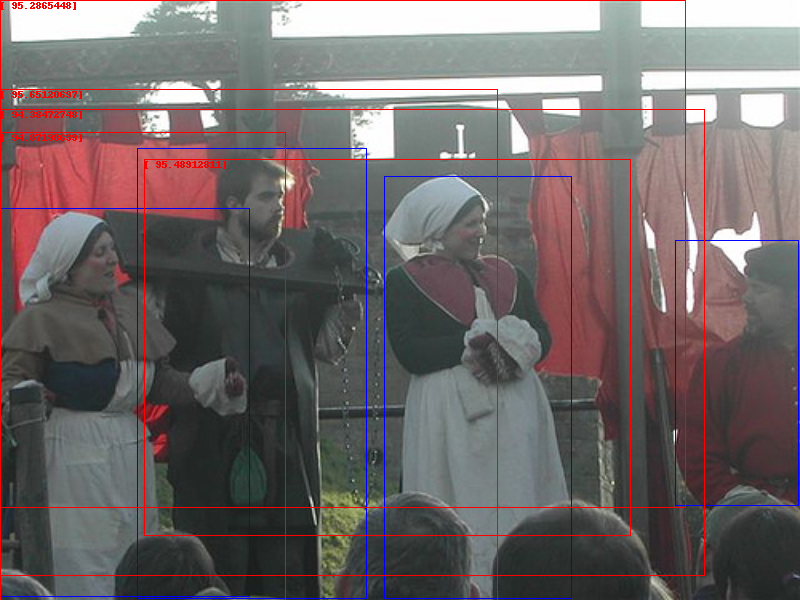

In [48]:
"""with open("/home/hnguyen/Wordspace/playground/fail_image.pkl", "rb") as f:
    image_arr, gt = pickle.load(f)
image_arr = Variable(torch.Tensor(image_arr))
gt = Variable(torch.Tensor(gt))"""
image_arr, gt, _ = iterator.next()
image_arr = Variable(image_arr)
gt = Variable(gt)

logits, regressions = rpn(image_arr)
logits = logits.view(1, 2, 9 * logits.size(2), logits.size(3))
scores = softmax_m(logits)

width = Variable(torch.Tensor([logits.size(3)]))                                                                                                                   
height = Variable(torch.Tensor([logits.size(2)]))
im_h = Variable(torch.Tensor([image_arr.size(2)]))                                                                                                                     
im_w = Variable(torch.Tensor([image_arr.size(3)]))  
bboxes, scores = proposal(regressions, scores, im_w, im_h)

image = image_arr.cpu().data.numpy()
image = image * PIXEL_STDS
image = image + PIXEL_MEANS
image = image * 255.0
image = image.squeeze().transpose(1, 2, 0).round().astype(np.uint8)
image = Image.fromarray(image)

image_draw = ImageDraw.ImageDraw(image)

true_bbox = gt.data.numpy()
for i in range(true_bbox.shape[0]):
    image_draw.rectangle(true_bbox[i, :], outline="blue")
    
pred_bbox = bboxes.data.numpy()
pred_score = scores.data.numpy()

for i in range(5):
    image_draw.text(pred_bbox[i, 1:3], str(pred_score[i] * 100.), fill="red")
    image_draw.rectangle(pred_bbox[i, 1:], outline="red")

image

In [38]:
with open("/home/hnguyen/Wordspace/playground/fail_image_3.pkl", "w") as f:
    pickle.dump((image_arr.data.numpy(), gt.data.numpy()), f)